In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [2]:
def map_edt(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        # transformation from distance from the center
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

In [3]:
# data files selected:
# OK 2023_11_28 pAAA Tweez Pos 1
# OK 2023_12_06 pLPT20 Tweez Pos 0 ## here
# OK 2023_12_08 pLPT20 Tweez Pos 0 ## ppt

# OK 2023_12_06 pLPT20 IPTG Tweez pos 15
# OK 2023_12_08 pLPT20 aTc Tweez pos 34

# OK 2023_12_04 pLPT107 Tweez pos 14
# OK 2023_12_04 pLPT107 IPTG Tweez pos 31
# OK 2023_12_08 pLPT107 aTc Ti Pos 21

In [3]:
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
plasmid_name = {'pLPT20&pLPT41': 'Single reporter', 
                'pLPT119&pLPT41': 'Single reporter no deg tag', 
                'pAAA': 'Triple constitutive reporter', 
                'pLPT107&pLPT41': 'Triple reporter '}

exp_date = '2023_11_28'
vector = 'pAAA'
#vector = 'pLPT20&pLPT41'
#vector = 'pLPT119&pLPT41'
#vector = 'pLPT107&pLPT41'


chem = ''
#chem = 'IPTG'
#chem = 'aTc'
scope_name = 'Tweez scope'
pos = 1

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'

if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

fname

'2023_11_28_10x_1.0x_pAAA_TiTweez_Pos1.ome.tif'

#### Construct files

In [4]:
path_im = os.path.join(path, fname)
path_results = os.path.join(path, folder_results, f"pos{pos}")

im_all = imread(path_im)
tf = 216
im_all = im_all[:tf,:,:,:ph_chn]
nt,nx,ny,nc = im_all.shape
print(im_all.shape)

bg = np.zeros((nc,))
for c in range(nc):
    bg[c] = im_all[0,:100,:100,c].mean()

edt = np.load(os.path.join(path_results,'edt.npy'))[:tf,:,:]

KeyboardInterrupt: 

In [ ]:
nr = 64
rw = 16
rs = np.linspace(rw, edt.max(), nr)

cov = np.zeros((nt,nr,nc,nc))
corr = np.zeros((nt,nr,nc))
mean = np.zeros((nt,nr,nc))
for t in range(nt):
    for ri in range(nr):
        tedt = edt[t,:,:]
        idx = np.abs(tedt - rs[ri]) < rw        
        if np.sum(idx)>0:
            #plt.figure()
            if fluo_chns == 3:
                ntim0 = im_all[t,:,:,rfp_chn].astype(float) - bg[rfp_chn]
                ntim1 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim2 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]
                x,y,z = ntim0[idx], ntim1[idx], ntim2[idx]
                C = np.cov(np.stack([x, y, z]))
                cov[t,ri,:,:] = C
                corr[t,ri,0] = np.corrcoef(x, y)[0,1]
                corr[t,ri,1] = np.corrcoef(x, z)[0,1]
                corr[t,ri,2] = np.corrcoef(y, z)[0,1]
                mean[t,ri,rfp_chn] = x.mean()
                mean[t,ri,yfp_chn] = y.mean()
                mean[t,ri,cfp_chn] = z.mean()
            elif fluo_chns == 2:                
                ntim0 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim1 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]               
                x,y = ntim0[idx], ntim1[idx]
                C = np.cov(np.stack([x, y]))
                cov[t,ri,:,:] = C
                corr[t,ri,0] = np.corrcoef(x, y)[0,1]
                corr[t,ri,1] = np.corrcoef(y, x)[0,1]
                mean[t,ri,yfp_chn] = x.mean()
                mean[t,ri,cfp_chn] = y.mean()
                
np.save(os.path.join(path_results, 'cov.npy'), cov)            
np.save(os.path.join(path_results, 'corr.npy'), corr)
np.save(os.path.join(path_results, 'mean.npy'), mean)

In [ ]:
## FROM FILES
#cov = np.load(os.path.join(path_results, 'cov.npy'))
#corr = np.load(os.path.join(path_results, 'corr.npy'))
#mean = np.load(os.path.join(path_results, 'mean.npy'))

In [15]:
corr_map = np.zeros_like(corr)
mean_map = np.zeros_like(mean)
for c in range(fluo_chns):
    corr_map[:,:,c] = warp(corr[:,:,c], map_edt, {'edt':edt, 'rs':rs})
    mean_map[:,:,c] = warp(mean[:,:,c], map_edt, {'edt':edt, 'rs':rs})
corr_map[np.isnan(corr)] = np.nan
mean_map[np.isnan(mean)] = np.nan

np.save(os.path.join(path_results, 'corr_map.npy'), corr_map)
np.save(os.path.join(path_results, 'mean_map.npy'), mean_map)

In [5]:
## FROM FILES
#corr_map = np.load(os.path.join(path_results, 'corr_map.npy'))
#mean_map = np.load(os.path.join(path_results, 'mean_map.npy'))

#### Correlation kymos

In [6]:
# for plot labels
df = pd.read_excel('../data_processed.xlsx')
## preparing labels
df_pos = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) &
    (df.Machine == scope_name) &
    (df.DNA == vector) &
    (df.Position == pos)]

j = df_pos.index[0]
df_pos.loc[:, 't_im'] = pd.to_datetime(df_pos['t_im'], format='%H:%M:%S')
df_pos.loc[:, 't_incub'] = pd.to_datetime(df_pos['t_incub'], format='%H:%M:%S')

time_im = df_pos.loc[j, 't_im']
time_incub = df_pos.loc[j, 't_incub']

delta_im = timedelta(hours=time_im.hour, minutes=time_im.minute, seconds=time_im.second)
delta_incub = timedelta(hours=time_incub.hour, minutes=time_incub.minute, seconds=time_incub.second)

# Calculate the difference
incub_time_s = delta_im - delta_incub
incub_time_n = incub_time_s.total_seconds() / 60

time_points = np.arange(0, df_pos.loc[j, 'exp length'])[:nt] * 10 + incub_time_n
time_strings = [f"{int(tp // 60):02d}" for tp in time_points]  # Ensure two digits for hours

# Select labels at intervals (e.g., every 75 points)
interval = 30
indices = np.arange(0, len(time_points), interval)
selected_time_strings = [time_strings[i] for i in indices]

## distance labels
ylim = int(edt.max() * df_pos['um_px'].values[0])
edt_max = edt.max(axis=(1,2))
radius = edt_max * df_pos['um_px'].values[0]
yticks = np.linspace(-ylim, ylim, num=7).astype('int')

NameError: name 'nt' is not defined

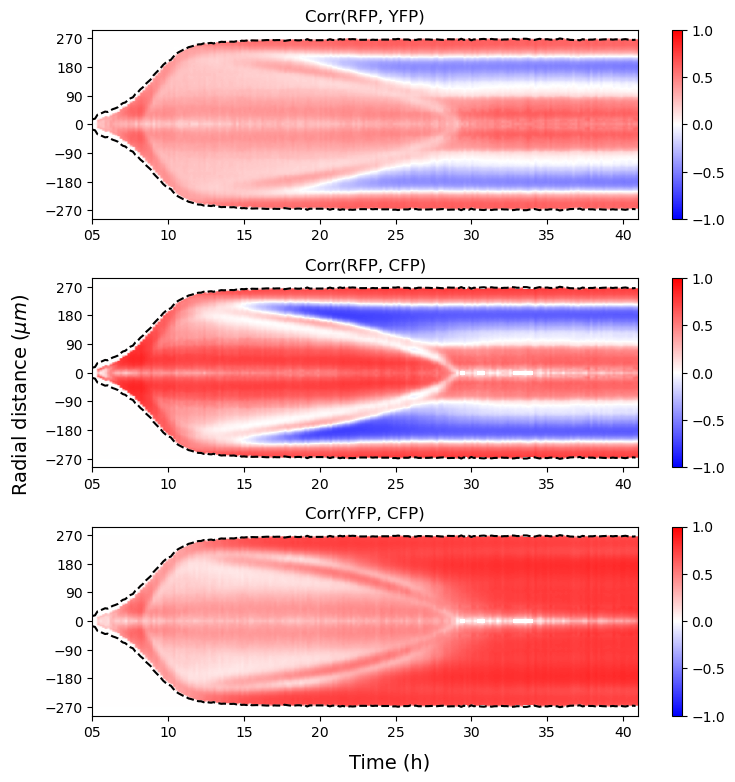

In [17]:
# Plotting
t0 = 0

if fluo_chns == 3:
    plt.figure(figsize=(8, 8))
    
    ax1 = plt.subplot(3, 1, 1)
    plt.imshow(np.hstack([corr_map[t0:, ::-1, 0], corr_map[t0:, :, 0]]).transpose(), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', 
               cmap='bwr', 
               vmin=-1, 
               vmax=1)
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    plt.title('Corr(RFP, YFP)')
    plt.colorbar()

    ax2 = plt.subplot(3, 1, 2)
    plt.imshow(np.hstack([corr_map[t0:, ::-1, 1], corr_map[t0:, :, 1]]).transpose(), 
               extent=[t0, nt, -ylim, ylim],  
               aspect='auto', 
               cmap='bwr', 
               vmin=-1, 
               vmax=1)
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    plt.title('Corr(RFP, CFP)')
    plt.colorbar()
    
    ax3 = plt.subplot(3, 1, 3)
    plt.imshow(np.hstack([corr_map[t0:, ::-1, 2], corr_map[t0:, :, 2]]).transpose(), 
               extent=[t0, nt, -ylim, ylim],  
               aspect='auto', 
               cmap='bwr', 
               vmin=-1, 
               vmax=1)
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    plt.title('Corr(YFP, CFP)')
    plt.colorbar()
    
    # Set x-ticks and labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xticks(indices)
        ax.set_xticklabels(selected_time_strings)
        ax.set_yticks(yticks)
        
    # Add shared x and y labels
    plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch5/corr_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

elif fluo_chns == 2:
    plt.figure(figsize=(8, 8/3))
    
    ax1 = plt.subplot(1, 1, 1)
    plt.imshow(np.hstack([corr_map[t0:, ::-1, 0], corr_map[t0:, :, 0]]).transpose(), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', 
               cmap='bwr', 
               vmin=-1, 
               vmax=1)
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    plt.title('Corr(RFP, YFP)')
    plt.colorbar()

    ax1.set_xticks(indices)
    ax1.set_xticklabels(selected_time_strings)
    ax1.set_yticks(yticks)    
    
    # Add shared x and y labels
    plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch5/corr_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()        

#### Mean fluo kymos

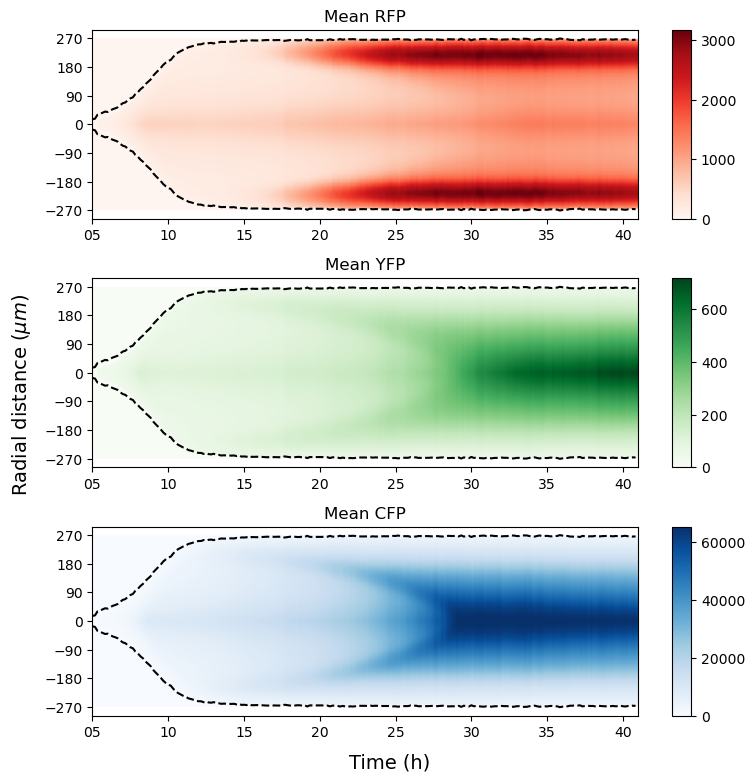

In [232]:
t0 = 0

## distance labels
ylim = int(edt.max() * df_pos['um_px'].values[0])
edt_max = edt.max(axis=(1,2))
radius = edt_max * df_pos['um_px'].values[0]
yticks = np.linspace(-ylim, ylim, num=7)

if fluo_chns == 3:
    mean_mapr = np.zeros_like(mean_map)
    mean_mapy = np.zeros_like(mean_map)
    mean_mapc = np.zeros_like(mean_map)
    
    mean_mapr[:,:,0] = mean_map[:,:,rfp_chn]
    mean_mapy[:,:,1] = mean_map[:,:,yfp_chn]
    mean_mapc[:,:,2] = mean_map[:,:,cfp_chn]
    
    plt.figure(figsize=(8, 8))
    
    plt.subplot(3,1,1)
    plt.imshow(np.hstack([mean_mapr[t0:,::-1,0], mean_mapr[t0:,:,0]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Reds')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean RFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    
    plt.subplot(3,1,2)
    plt.imshow(np.hstack([mean_mapy[t0:,::-1,1], mean_mapy[t0:,:,1]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Greens')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean YFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    
    plt.subplot(3,1,3)
    plt.imshow(np.hstack([mean_mapc[t0:,::-1,2], mean_mapc[t0:,:,2]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Blues')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean CFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)

    # Add shared x and y labels
    plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch5/mean_fluo_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    
elif fluo_chns == 2:
    #mean_mapr = np.zeros_like(mean_map)
    mean_mapy = np.zeros_like(mean_map)
    mean_mapc = np.zeros_like(mean_map)
    
    #mean_mapr[:,:,0] = mean_map[:,:,rfp_chn]
    mean_mapy[:,:,0] = mean_map[:,:,yfp_chn]
    mean_mapc[:,:,1] = mean_map[:,:,cfp_chn]
    
    plt.figure(figsize=(8, 8/3*2))
    
    plt.subplot(2,1,1)
    plt.imshow(np.hstack([mean_mapy[t0:,::-1,0], mean_mapy[t0:,:,0]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Greens')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean YFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    
    plt.subplot(2,1,2)
    plt.imshow(np.hstack([mean_mapc[t0:,::-1,1], mean_mapc[t0:,:,1]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Blues')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean CFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    
    # Add shared x and y labels
    plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch5/mean_fluo_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()#

#### From file

In [ ]:
# data files selected:
# OK 2023_11_28 pAAA Tweez Pos 1

# OK 2023_12_08 pLPT20 Tweez Pos 0
# OK 2023_12_06 pLPT20 IPTG Tweez pos 15
# OK 2023_12_08 pLPT20 aTc Tweez pos 34

# OK 2023_12_04 pLPT107 Tweez pos 14
# OK 2023_12_04 pLPT107 IPTG Tweez pos 31
# OK 2023_12_08 pLPT107 aTc Ti Pos 21

In [51]:
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
plasmid_name = {'pLPT20&pLPT41': 'Single reporter', 
                'pLPT119&pLPT41': 'Single reporter no deg tag', 
                'pAAA': 'Triple constitutive reporter', 
                'pLPT107&pLPT41': 'Triple reporter '}

exp_date = '2023_12_08'
#vector = 'pAAA'
#vector = 'pLPT20&pLPT41'
vector = 'pLPT107&pLPT41'


#chem = ''
#chem = 'IPTG'
chem = 'aTc'
scope_name = 'Ti scope'
pos = 21

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'

if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

fname

'2023_12_08_10x_1.0x_pLPT107&41_Ti_Pos21.ome.tif'

In [54]:
# from file
#tf = 216
tf = 316
corr_map = np.load(os.path.join(path_results, 'corr_map.npy'))[:tf,:,:]
mean_map = np.load(os.path.join(path_results, 'mean_map.npy'))[:tf,:,:]
edt = np.load(os.path.join(path_results,'edt.npy'))[:tf,:,:]

nt,_,_ = corr_map.shape

# for plot labels
df = pd.read_excel('../data_processed.xlsx')
## preparing labels
df_pos = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) &
    (df.Machine == scope_name) &
    (df.DNA == vector) &
    (df.Position == pos)]

j = df_pos.index[0]
df_pos.loc[:, 't_im'] = pd.to_datetime(df_pos['t_im'], format='%H:%M:%S')
df_pos.loc[:, 't_incub'] = pd.to_datetime(df_pos['t_incub'], format='%H:%M:%S')

time_im = df_pos.loc[j, 't_im']
time_incub = df_pos.loc[j, 't_incub']

delta_im = timedelta(hours=time_im.hour, minutes=time_im.minute, seconds=time_im.second)
delta_incub = timedelta(hours=time_incub.hour, minutes=time_incub.minute, seconds=time_incub.second)

# Calculate the difference
incub_time_s = delta_im - delta_incub
incub_time_n = incub_time_s.total_seconds() / 60

time_points = np.arange(0, df_pos.loc[j, 'exp length'])[:nt] * 10 + incub_time_n
time_strings = [f"{int(tp // 60):02d}" for tp in time_points]  # Ensure two digits for hours

# Select labels at intervals (e.g., every 75 points)
interval = 30
indices = np.arange(0, len(time_points), interval)
selected_time_strings = [time_strings[i] for i in indices]

## distance labels
ylim = int(edt.max() * df_pos['um_px'].values[0])
edt_max = edt.max(axis=(1,2))
radius = edt_max * df_pos['um_px'].values[0]
yticks = np.linspace(-ylim, ylim, num=7).astype('int')

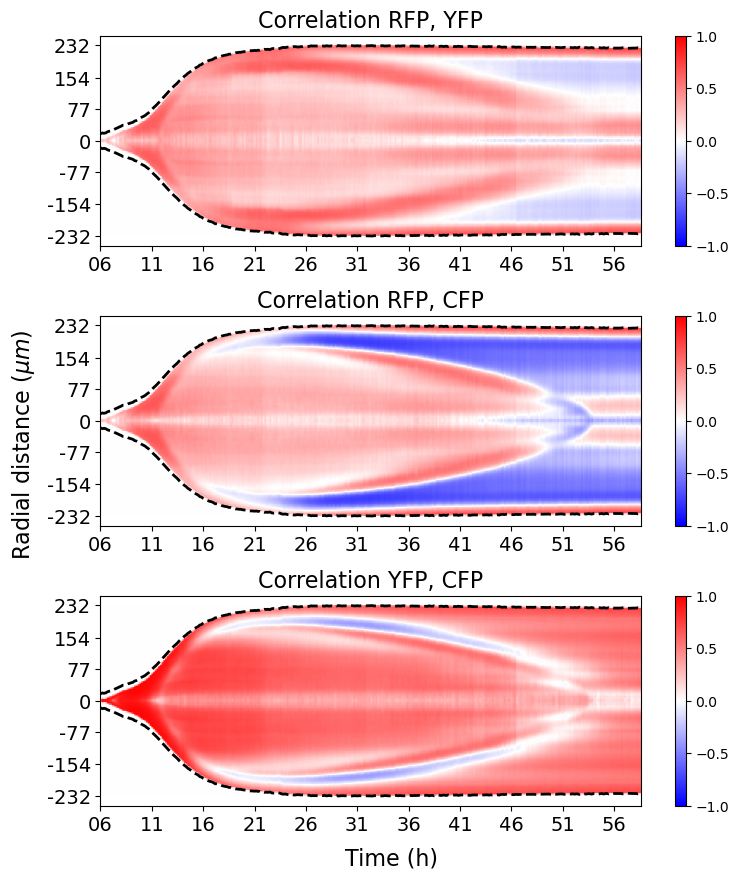

In [55]:
# Plotting
t0 = 0

if fluo_chns == 3:
    plt.figure(figsize=(8, 9))
    
    ax1 = plt.subplot(3, 1, 1)
    plt.imshow(np.hstack([corr_map[t0:, ::-1, 0], corr_map[t0:, :, 0]]).transpose(), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', 
               cmap='bwr', 
               vmin=-1, 
               vmax=1)
    plt.plot(np.arange(nt), radius, 'k--',linewidth=2)
    plt.plot(np.arange(nt), -radius, 'k--',linewidth=2)
    plt.title('Correlation RFP, YFP',fontsize=16)
    plt.colorbar()

    ax2 = plt.subplot(3, 1, 2)
    plt.imshow(np.hstack([corr_map[t0:, ::-1, 1], corr_map[t0:, :, 1]]).transpose(), 
               extent=[t0, nt, -ylim, ylim],  
               aspect='auto', 
               cmap='bwr', 
               vmin=-1, 
               vmax=1)
    plt.plot(np.arange(nt), radius, 'k--',linewidth=2)
    plt.plot(np.arange(nt), -radius, 'k--',linewidth=2)
    plt.title('Correlation RFP, CFP',fontsize=16)
    plt.colorbar()
    
    ax3 = plt.subplot(3, 1, 3)
    plt.imshow(np.hstack([corr_map[t0:, ::-1, 2], corr_map[t0:, :, 2]]).transpose(), 
               extent=[t0, nt, -ylim, ylim],  
               aspect='auto', 
               cmap='bwr', 
               vmin=-1, 
               vmax=1)
    plt.plot(np.arange(nt), radius, 'k--',linewidth=2)
    plt.plot(np.arange(nt), -radius, 'k--',linewidth=2)
    plt.title('Correlation YFP, CFP',fontsize=16)
    plt.colorbar()
    
    # Set x-ticks and labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xticks(indices)
        ax.set_xticklabels(selected_time_strings,fontsize=14)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f'{int(tick)}' for tick in yticks],fontsize=14)
        
    # Add shared x and y labels
    plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=16)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=16)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch5/corr_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

elif fluo_chns == 2:
    plt.figure(figsize=(8, 3.5))
    
    ax1 = plt.subplot(1, 1, 1)
    plt.imshow(np.hstack([corr_map[t0:, ::-1, 0], corr_map[t0:, :, 0]]).transpose(), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', 
               cmap='bwr', 
               vmin=-1, 
               vmax=1)
    plt.plot(np.arange(nt), radius, 'k--',linewidth=2)
    plt.plot(np.arange(nt), -radius, 'k--',linewidth=2)
    plt.title('Correlation YFP, CFP',fontsize=16)
    plt.colorbar()

    ax1.set_xticks(indices)
    ax1.set_xticklabels(selected_time_strings,fontsize=14)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([f'{int(tick)}' for tick in yticks],fontsize=14)
    
    # Add shared x and y labels
    plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=16)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=16)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch5/corr_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

#### Mean fluo kymo from file

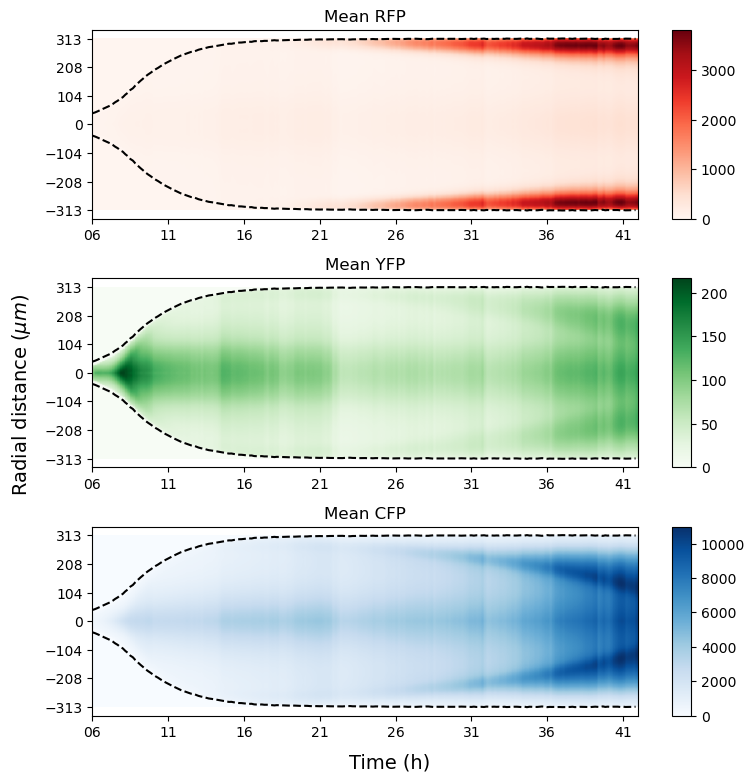

In [235]:
t0 = 0

## distance labels
ylim = int(edt.max() * df_pos['um_px'].values[0])
edt_max = edt.max(axis=(1,2))
radius = edt_max * df_pos['um_px'].values[0]

if fluo_chns == 3:
    mean_mapr = np.zeros_like(mean_map)
    mean_mapy = np.zeros_like(mean_map)
    mean_mapc = np.zeros_like(mean_map)
    
    mean_mapr[:,:,0] = mean_map[:,:,rfp_chn]
    mean_mapy[:,:,1] = mean_map[:,:,yfp_chn]
    mean_mapc[:,:,2] = mean_map[:,:,cfp_chn]
    
    plt.figure(figsize=(8, 8))
    
    plt.subplot(3,1,1)
    plt.imshow(np.hstack([mean_mapr[t0:,::-1,0], mean_mapr[t0:,:,0]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Reds')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean RFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    
    plt.subplot(3,1,2)
    plt.imshow(np.hstack([mean_mapy[t0:,::-1,1], mean_mapy[t0:,:,1]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Greens')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean YFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    
    plt.subplot(3,1,3)
    plt.imshow(np.hstack([mean_mapc[t0:,::-1,2], mean_mapc[t0:,:,2]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Blues')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean CFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)

    # Add shared x and y labels
    plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch5/mean_fluo_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    
elif fluo_chns == 2:
    #mean_mapr = np.zeros_like(mean_map)
    mean_mapy = np.zeros_like(mean_map)
    mean_mapc = np.zeros_like(mean_map)
    
    #mean_mapr[:,:,0] = mean_map[:,:,rfp_chn]
    mean_mapy[:,:,0] = mean_map[:,:,yfp_chn]
    mean_mapc[:,:,1] = mean_map[:,:,cfp_chn]
    
    plt.figure(figsize=(8, 8/3*2))
    
    plt.subplot(2,1,1)
    plt.imshow(np.hstack([mean_mapy[t0:,::-1,0], mean_mapy[t0:,:,0]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Greens')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean YFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    
    plt.subplot(2,1,2)
    plt.imshow(np.hstack([mean_mapc[t0:,::-1,1], mean_mapc[t0:,:,1]]).transpose([1, 0]), 
               extent=[t0, nt, -ylim, ylim], 
               aspect='auto', cmap='Blues')
    plt.plot(np.arange(nt), radius, 'k--')
    plt.plot(np.arange(nt), -radius, 'k--')
    #plt.xlabel('Time (h)')
    plt.title('Mean CFP')
    plt.yticks(ticks=yticks)
    plt.colorbar(aspect=10)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    
    # Add shared x and y labels
    plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=14)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch5/mean_fluo_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()#

In [202]:
fname

'2023_12_06_10x_1.0x_pLPT20&41_TiTweez_Pos11.ome.tif'

In [211]:
chem

'IPTG'